In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool

from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders.cat_boost import CatBoostEncoder

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'data_description.txt', 'sample_submission.csv']


In [2]:
class Processor:
    X = pd.DataFrame()
    y = pd.DataFrame()
    filename = ''
    target_column = None
    cat_encoders = {}
    
    def __init__(self, filename, target_column = None):
        self.filename = filename
        self.target_column = target_column
        self.read()
    
    def read(self):
        self.X = pd.read_csv(self.filename)
        if self.target_column != None:
            self.y = self.X[self.target_column].copy()
            self.X.drop([self.target_column], axis=1, inplace=True)
        print(self.X.shape)
       
    def plot_heatmap(self):
        f,ax = plt.subplots(figsize=(32, 28))
        sns.heatmap(self.X.corr(), annot=True, linewidths=.8, fmt= '.1f',ax=ax)
        plt.plot()        
    
    
    def clean(self):
        self.drop_nan_and_nocorr_columns()
        self.set_median_for_numeric_nan()
        self.X.dropna(axis=1, inplace=True)
        self.encode_label_columns()
        print(self.X.shape)

    def drop_nan_and_nocorr_columns(self):
        columns_to_drop = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature', 'Id','EnclosedPorch','3SsnPorch',
                           'ScreenPorch','MiscVal','MoSold','YrSold','MasVnrArea', 'BsmtFinSF2','LowQualFinSF',
                           'OverallCond','BsmtHalfBath', 'Utilities','Street','PoolArea','MasVnrType','Heating',
                           'Condition2','Functional',
                           # small number of nans
                           'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
                          'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
                          'GarageCond',  'GarageFinish', 'GarageQual', 'GarageType',
                          # does not work for test set
                          'KitchenQual', 'MSZoning','SaleType']
        self.X.drop(columns_to_drop, axis=1, inplace=True)     
        
    def set_median_for_numeric_nan(self):
        for column in self.X.columns:
            if np.issubdtype(self.X[column].dtype, np.number):
                mask = self.X.loc[self.X[column].isna()]
                df = self.X.iloc[mask.index]
                df[column] = self.X[column].median()
                self.X.iloc[mask.index] = df
                
    def encode_label_columns(self):
        columns_to_encode = ['MSSubClass','LotFrontage','LotArea','Neighborhood','OverallQual','YearBuilt','YearRemodAdd','BsmtFinSF1',
                             'BsmtUnfSF','TotalBsmtSF', '1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF',
                             'OpenPorchSF','BldgType', 
                             'CentralAir', 'Condition1',  
                             'Foundation',  
                             'HeatingQC', 'HouseStyle', 'LandContour', 'LandSlope', 'LotConfig','LotShape', 
                             'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition']
        for column in columns_to_encode:
            y = None
            encoder = CatBoostEncoder()
            if self.target_column != None:
                self.X[column] = encoder.fit_transform(self.X[column].values, self.y.values)
                self.cat_encoders[column] = encoder
            else:
                self.X[column] = self.cat_encoders[column].transform(self.X[column].values)


In [3]:
processor = Processor('../input/train.csv', 'SalePrice')
processor.clean()
processor.X.head()

(1460, 80)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1460, 39)


,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,SaleCondition
0,60.0,65.0,8450.0,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,...,1.0,8.0,0.0,2003.0,2.0,548.0,180921.195890,0.0,61.0,180921.195890
1,20.0,80.0,9600.0,194710.597945,194710.597945,180921.195890,194710.597945,180921.195890,180921.195890,194710.597945,...,1.0,6.0,1.0,1976.0,2.0,460.0,194710.597945,298.0,0.0,194710.597945
2,60.0,68.0,11250.0,180921.195890,190307.065297,194710.597945,190307.065297,194710.597945,194710.597945,190307.065297,...,1.0,6.0,1.0,2001.0,2.0,608.0,190307.065297,0.0,42.0,190307.065297
3,70.0,60.0,9550.0,202210.597945,198605.298973,180921.195890,198605.298973,180921.195890,204307.065297,198605.298973,...,1.0,7.0,1.0,1998.0,3.0,642.0,198605.298973,0.0,35.0,180921.195890
4,60.0,84.0,14260.0,181473.731963,186884.239178,181210.597945,186884.239178,180921.195890,188230.298973,186884.239178,...,1.0,9.0,1.0,2000.0,3.0,836.0,186884.239178,192.0,84.0,198605.298973


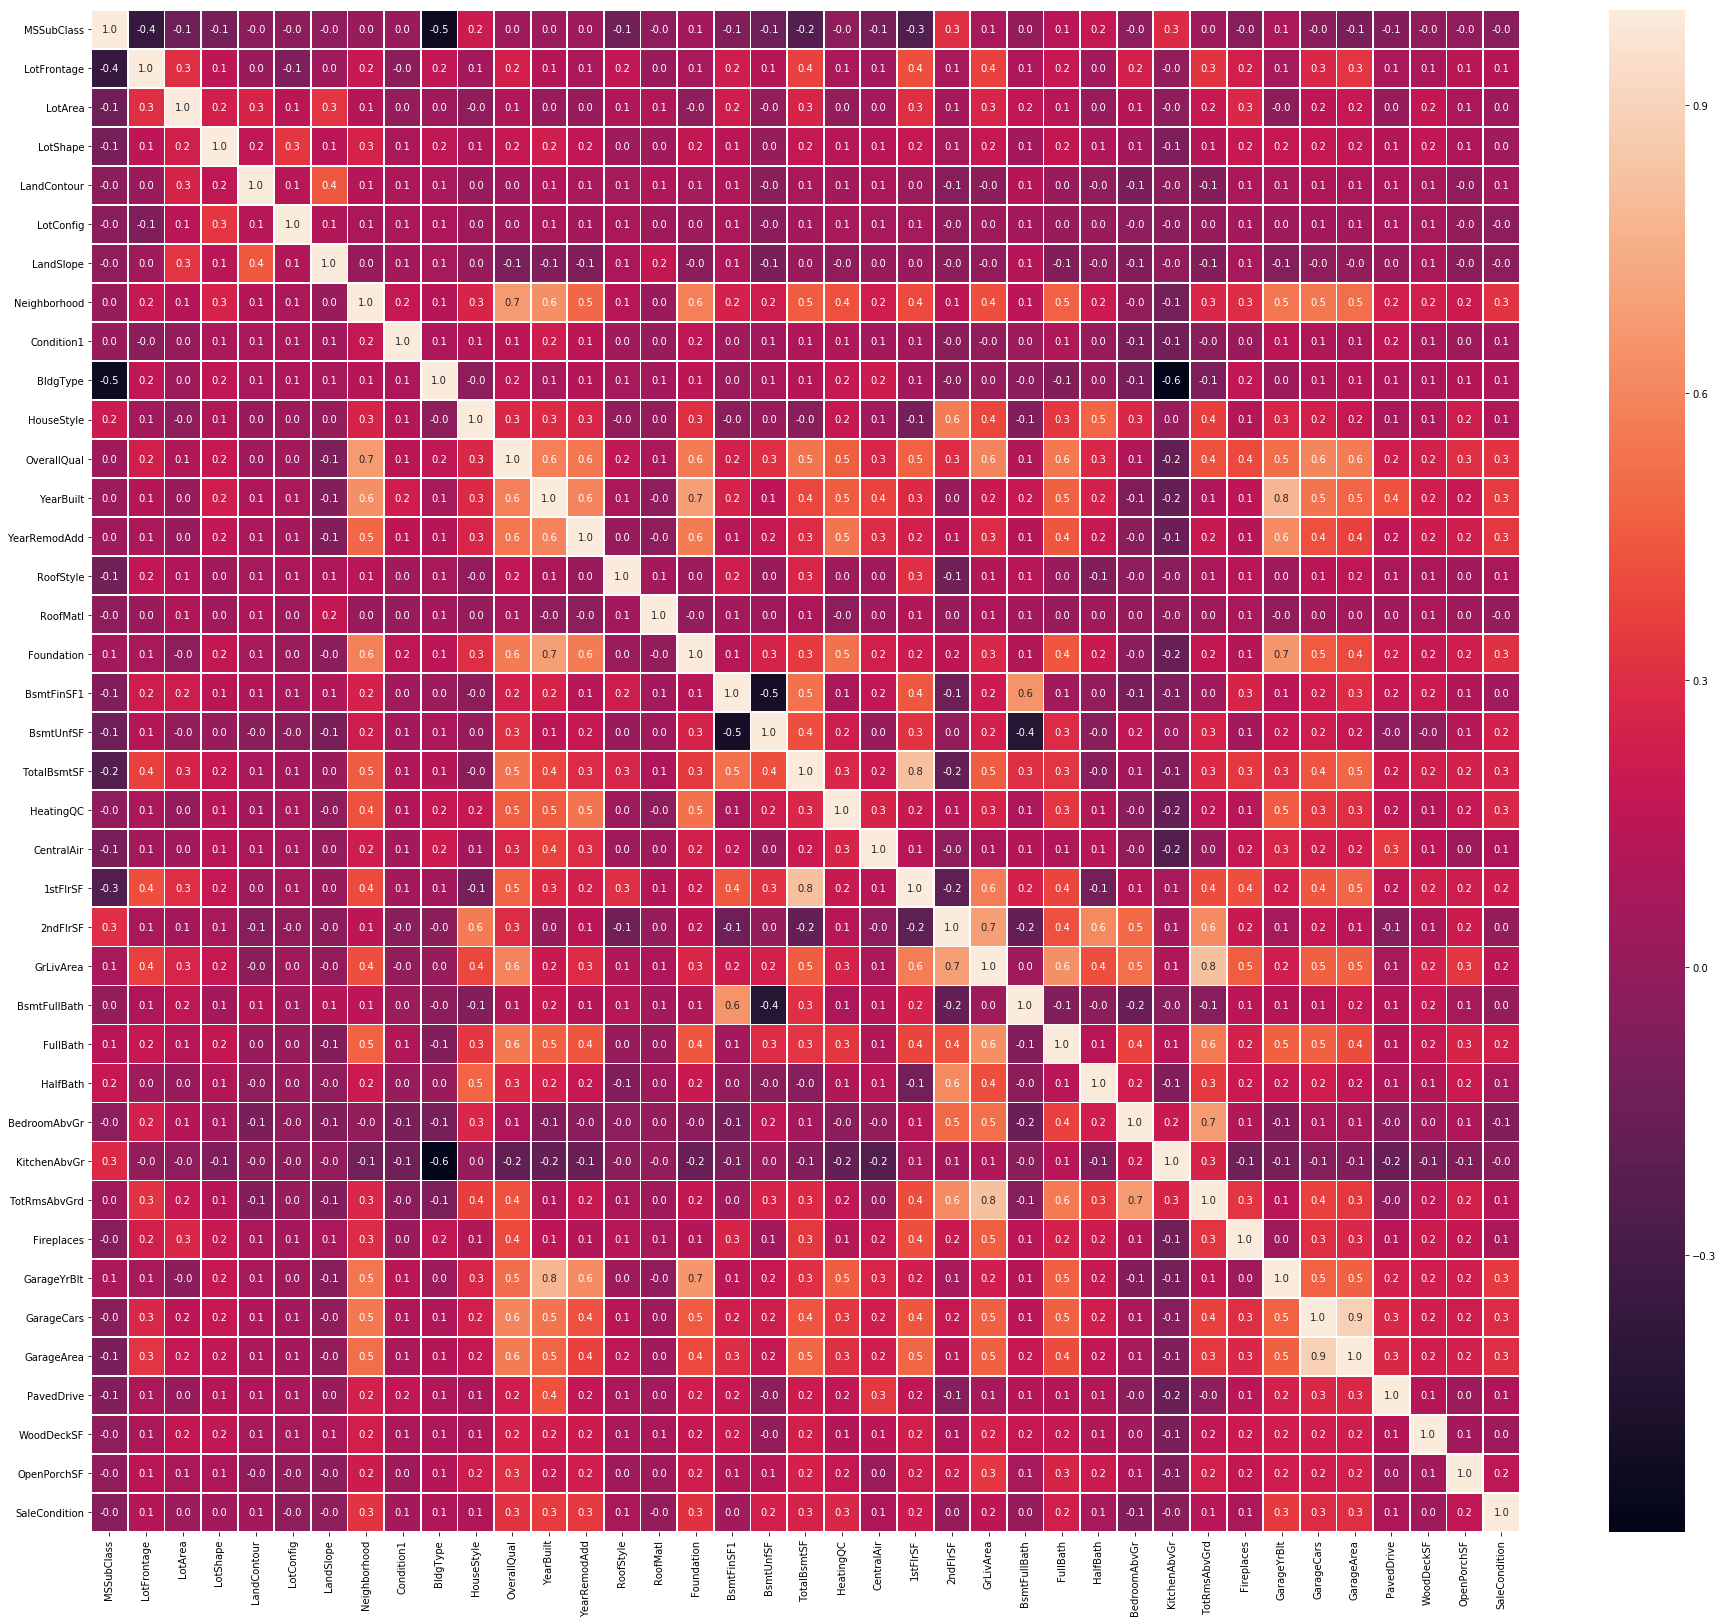

In [4]:
processor.plot_heatmap()

## LightGBM regressor

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = processor.X.copy()
y = processor.y.copy()


X_train1, X_valid1, y_train1, y_valid1 = train_test_split( X, y, test_size=0.25, random_state=42)
    
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train1, y_train1)
lgvalid = lgb.Dataset(X_valid1, y_valid1)

params = {
    'objective' : 'regression',
    'num_iterations' : 10000,
    'metric' : 'rmse',
    'num_leaves' : 500,
    'max_bin' : 500,
    'max_depth': 15,
    'bagging_fraction' : 0.6,
    'bagging_freq' : 15,
    'learning_rate' : 0.007,
    'feature_fraction' : 0.4,
    'verbosity' : 0
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(
    params,
    lgtrain,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=1000,
    verbose_eval=500,
    evals_result=evals_result
)

#print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_valid1, gbm.predict(X_valid1))))

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds.
[500]	train's rmse: 22623.4	valid's rmse: 29585.8
[1000]	train's rmse: 18010.4	valid's rmse: 27720
[1500]	train's rmse: 15471.7	valid's rmse: 27349.5
[2000]	train's rmse: 13474.9	valid's rmse: 27128.4
[2500]	train's rmse: 11840.9	valid's rmse: 27076.5
[3000]	train's rmse: 10517.2	valid's rmse: 27226.6
[3500]	train's rmse: 9482.13	valid's rmse: 27147.7
Early stopping, best iteration is:
[2550]	train's rmse: 11752.2	valid's rmse: 27009.2


Plotting metrics recorded during training...


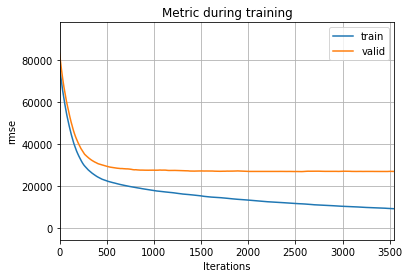

Plotting feature importances...


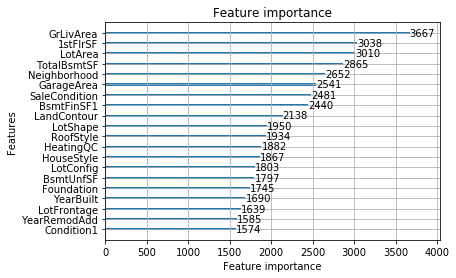

In [6]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()

In [7]:
processor_test = Processor('../input/test.csv')
id_values = processor_test.X['Id'].copy()
processor_test.clean()
predictions = gbm.predict(processor_test.X)
print(predictions.shape)
print(id_values.shape)

(1459, 80)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1459, 39)
(1459,)
(1459,)


In [8]:
output = pd.DataFrame({'Id': id_values, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)